In [ ]:
!git clone https://github.com/ch2343/scCRAFT.git

In [ ]:
%cd scCRAFT
!pip install .

In [ ]:
!pip install harmonypy

In [1]:
import scanpy as sc
import numpy as np
import scCRAFT
from scCRAFT.model import *
import harmonypy as hm
import pandas as pd
import time
import scvi
import anndata
import pandas as pd
from scipy.io import mmread
from scipy.sparse import csr_matrix
import umap
import matplotlib.pyplot as plt
import os
import tempfile
import scanorama
import scanpy as sc
import scvi
import seaborn as sns
import torch

/Users/sheena/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import warnings

sc.set_figure_params(figsize=(6, 6), frameon=False)
sns.set_theme()
torch.set_float32_matmul_precision("high")
save_dir = tempfile.TemporaryDirectory()

%config InlineBackend.print_figure_kwargs={"facecolor": "w"}
%config InlineBackend.figure_format="retina"

# Suppress specific ImportWarning
warnings.filterwarnings("ignore")

/Users/sheena/Library/Python/3.9/lib/python/site-packages/scanpy/_settings.py:488: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  IPython.display.set_matplotlib_formats(*ipython_format)
/Users/sheena/Library/Python/3.9/lib/python/site-packages/matplotlib_inline/config.py:54: DeprecationWarning: InlineBackend._print_figure_kwargs_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _update_figure_formatters(self):


In [3]:
adata = anndata.read_h5ad("../Lung_atlas_public.h5ad")
adata

AnnData object with n_obs × n_vars = 32472 × 15148
    obs: 'dataset', 'location', 'nGene', 'nUMI', 'patientGroup', 'percent.mito', 'protocol', 'sanger_type', 'size_factors', 'sampling_method', 'batch', 'cell_type', 'donor'
    layers: 'counts'

In [4]:
# preprocessing
adata.raw = adata
adata.layers["counts"] = adata.X.copy()
sc.pp.filter_cells(adata, min_genes=300)
sc.pp.filter_genes(adata, min_cells=5)
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=2000, batch_key='batch')
adata = adata[:, adata.var['highly_variable']]

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [7]:
embeddings_dict = []

# Scanorama

In [5]:
import anndata as ad

def split_batches(adata, batch_key, return_categories=False):
    """
    Split an AnnData object into a list of AnnData objects by batch.
    
    Parameters:
    - adata (AnnData): The AnnData object to split.
    - batch_key (str): The key in `adata.obs` used to identify batches.
    - return_categories (bool): Whether to return the unique categories (batch labels).

    Returns:
    - list: A list of AnnData objects, one for each batch.
    - list (optional): A list of unique batch categories, if `return_categories` is True.
    """
    if batch_key not in adata.obs:
        raise ValueError(f"Batch key '{batch_key}' not found in adata.obs.")
    
    categories = adata.obs[batch_key].unique().tolist()
    split_data = [adata[adata.obs[batch_key] == batch].copy() for batch in categories]
    
    if return_categories:
        return split_data, categories
    return split_data

Found 2000 genes among all datasets
[[0.00000000e+00 8.80300958e-01 2.93202293e-01 1.85362517e-01
  1.61825726e-02 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 1.09439124e-02 1.84678523e-02
  4.78796170e-03 4.32900433e-03 1.43805310e-02 4.10396717e-03]
 [0.00000000e+00 0.00000000e+00 6.67485667e-01 1.40836771e-01
  8.75518672e-02 4.75059382e-03 5.70071259e-03 8.15660685e-04
  0.00000000e+00 6.87757909e-04 1.50483396e-01 6.31828979e-02
  1.28266033e-02 1.29870130e-02 5.30973451e-02 9.97624703e-03]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 4.08681409e-01
  3.90041494e-02 8.19000819e-04 8.19000819e-04 0.00000000e+00
  0.00000000e+00 9.00900901e-03 3.93120393e-02 5.07780508e-02
  4.91400491e-03 0.00000000e+00 1.02876106e-01 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  5.89275192e-04 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 2.65173836e-02 5.03018109e-03
  5.89275192e-04 0.00000000e+00

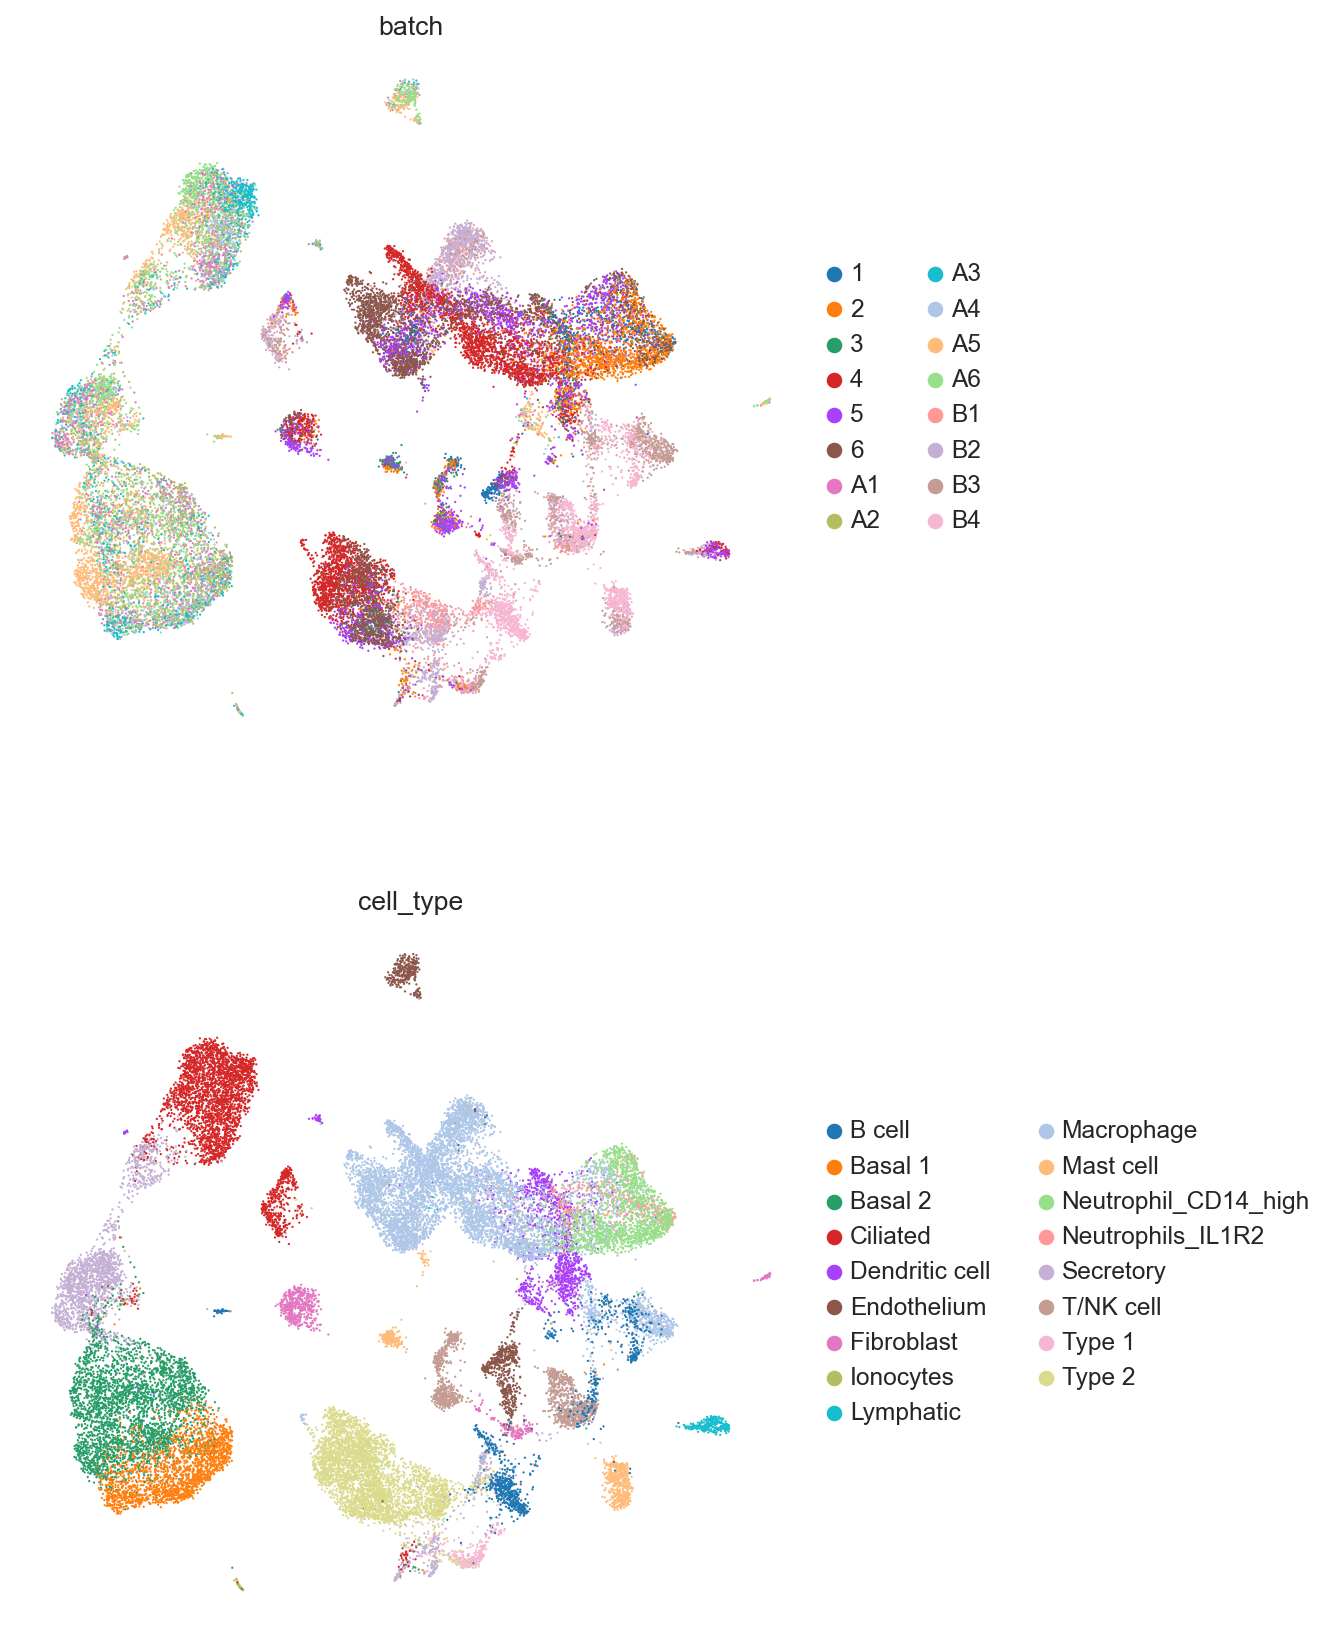

In [6]:
#Scanorama
# Save original order of cells
original_order = adata.obs_names.copy()

# Your existing Scanorama correction process
split, categories = split_batches(adata.copy(), 'batch', return_categories=True)
corrected = scanorama.correct_scanpy(split, return_dimred=True)
corrected = anndata.AnnData.concatenate(
    *corrected, batch_key='batch', batch_categories=categories, index_unique=None
)

# Reorder corrected data to match original order
corrected = corrected[original_order]

# Replace adata with corrected data
adatas = corrected.copy()

In [24]:
adata.obsm['X_scanorama'] = adatas.obsm['X_scanorama']

# Collect embeddings
embeddings_dict["X_scanorama"] = adata.obsm["X_scanorama"]

In [25]:
embeddings_dict.keys()

dict_keys(['X_scVI', 'X_harmony', 'X_scCRAFT', 'X_seurat', 'X_scanorama'])

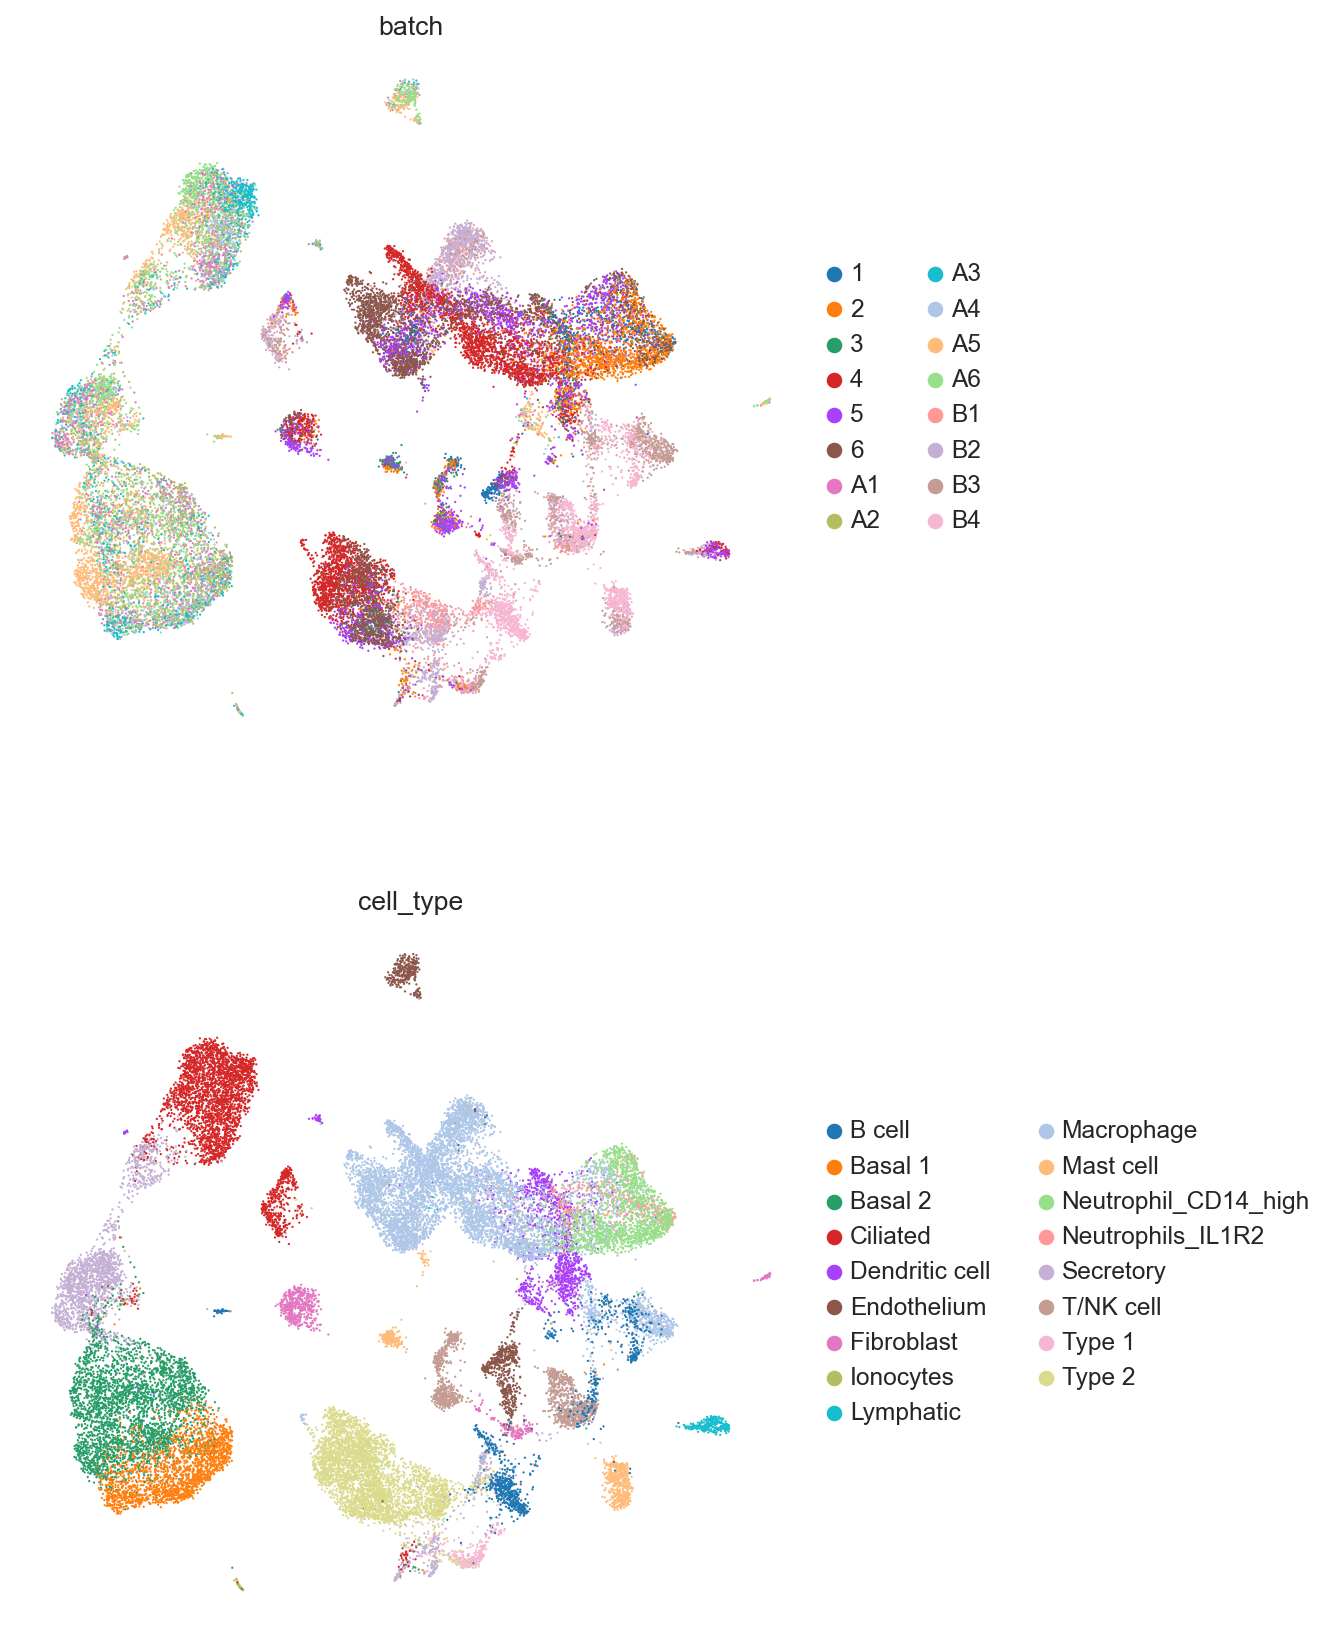

In [26]:
# Umap Plotting
sc.pp.neighbors(adata, n_pcs=30, use_rep="X_scanorama")
sc.tl.umap(adata)
sc.pl.umap(adata, color=["batch", "cell_type"], frameon=False, ncols=1)

# scCRAFT

/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_pca.py:325: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm["X_pca"] = X_pca
<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _A

150


<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()


Overall Progress:   0%|          | 0/150 [00:00<?, ?it/s]

Training completed in 580.59 seconds


<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()


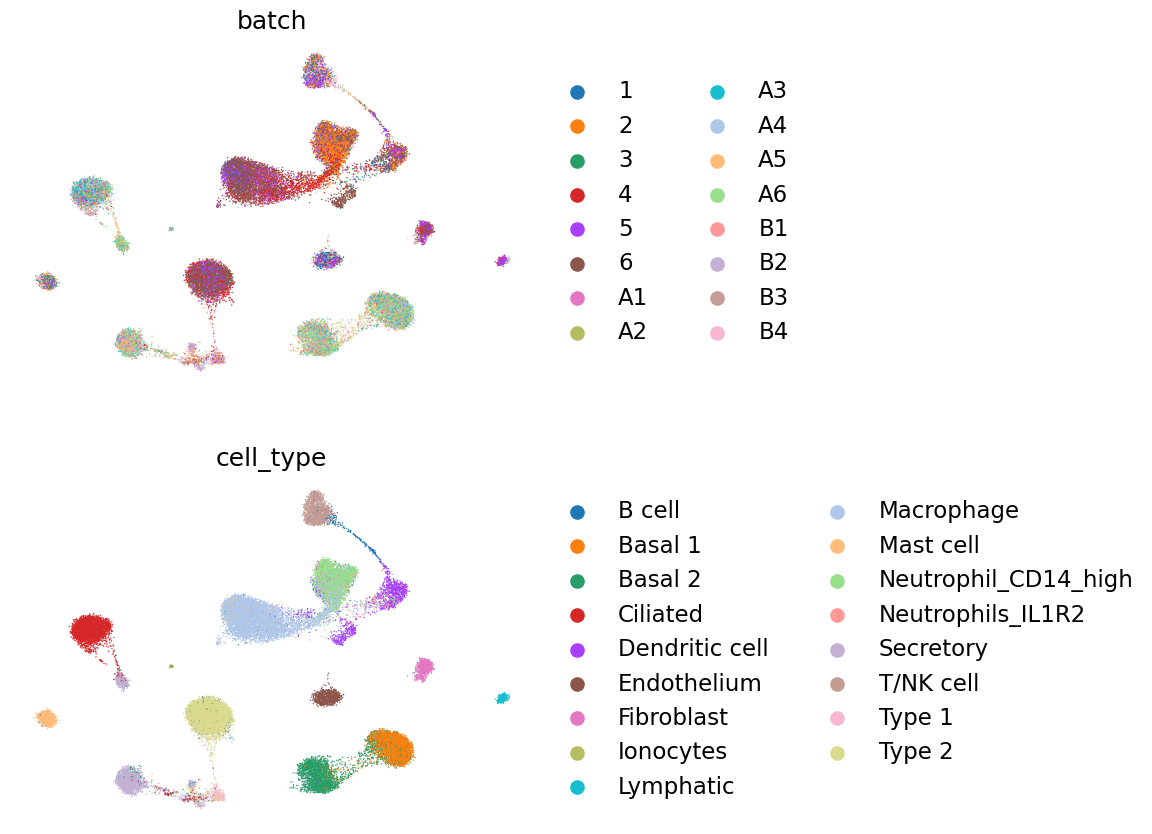

In [ ]:
# scCRAFT
multi_resolution_cluster(adata, resolution1 = 1, method = 'Leiden')
VAE = train_integration_model(adata, batch_key = 'batch', z_dim=256, d_coef = 0.2)
obtain_embeddings(adata, VAE)
sc.pp.neighbors(adata, use_rep="X_scCRAFT")
sc.tl.umap(adata, min_dist=0.5)

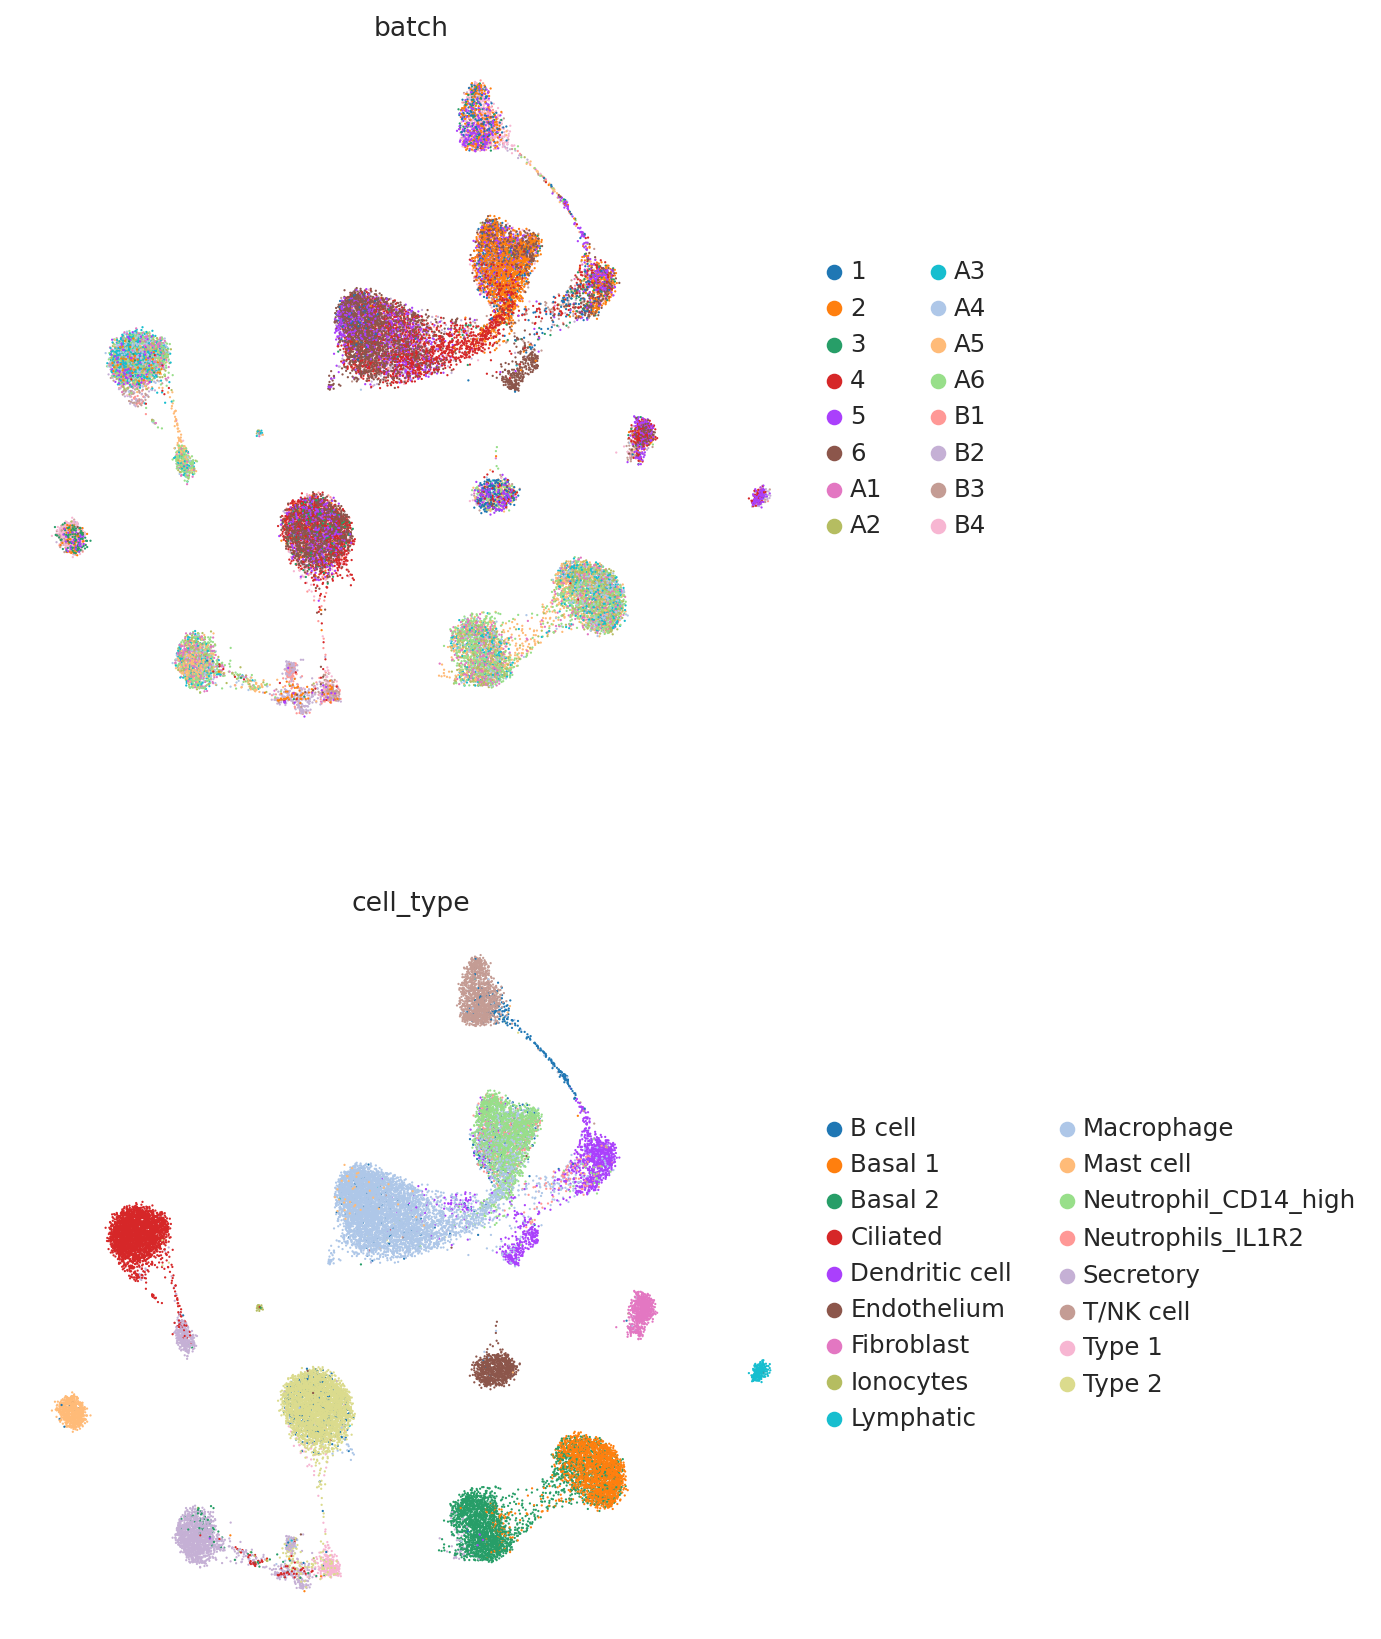

In [ ]:
sc.pl.umap(adata, color=["batch", "cell_type"], frameon=False, ncols=1)

In [ ]:
# Save embeddings
adata.obsm["X_scCRAFT"] = adata.obsm["X_scCRAFT"]

# Collect embeddings
embeddings_dict = {"X_scCRAFT": adata.obsm["X_scCRAFT"]}

# scVI

In [ ]:
# scVI
adata = adata.copy()
adata.layers['counts'] = adata.X
scvi.model.SCVI.setup_anndata(adata, layer="counts", batch_key="batch")
vae = scvi.model.SCVI(adata, n_layers=2, n_latent=50, gene_likelihood="nb")
vae.train()
adata.obsm["X_scVI"] = vae.get_latent_representation()
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.umap(adata, min_dist=0.5)

<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen impo

Epoch 273/273: 100%|██████████| 273/273 [08:35<00:00,  1.88s/it, v_num=1, train_loss_step=771, train_loss_epoch=766]

INFO: `Trainer.fit` stopped: `max_epochs=273` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=273` reached.



Epoch 273/273: 100%|██████████| 273/273 [08:35<00:00,  1.89s/it, v_num=1, train_loss_step=771, train_loss_epoch=766]


In [ ]:
# Save embeddings
adata.obsm["X_scVI"] = adata.obsm["X_scVI"]

# Collect embeddings
embeddings_dict["X_scVI"] = adata.obsm["X_scVI"]

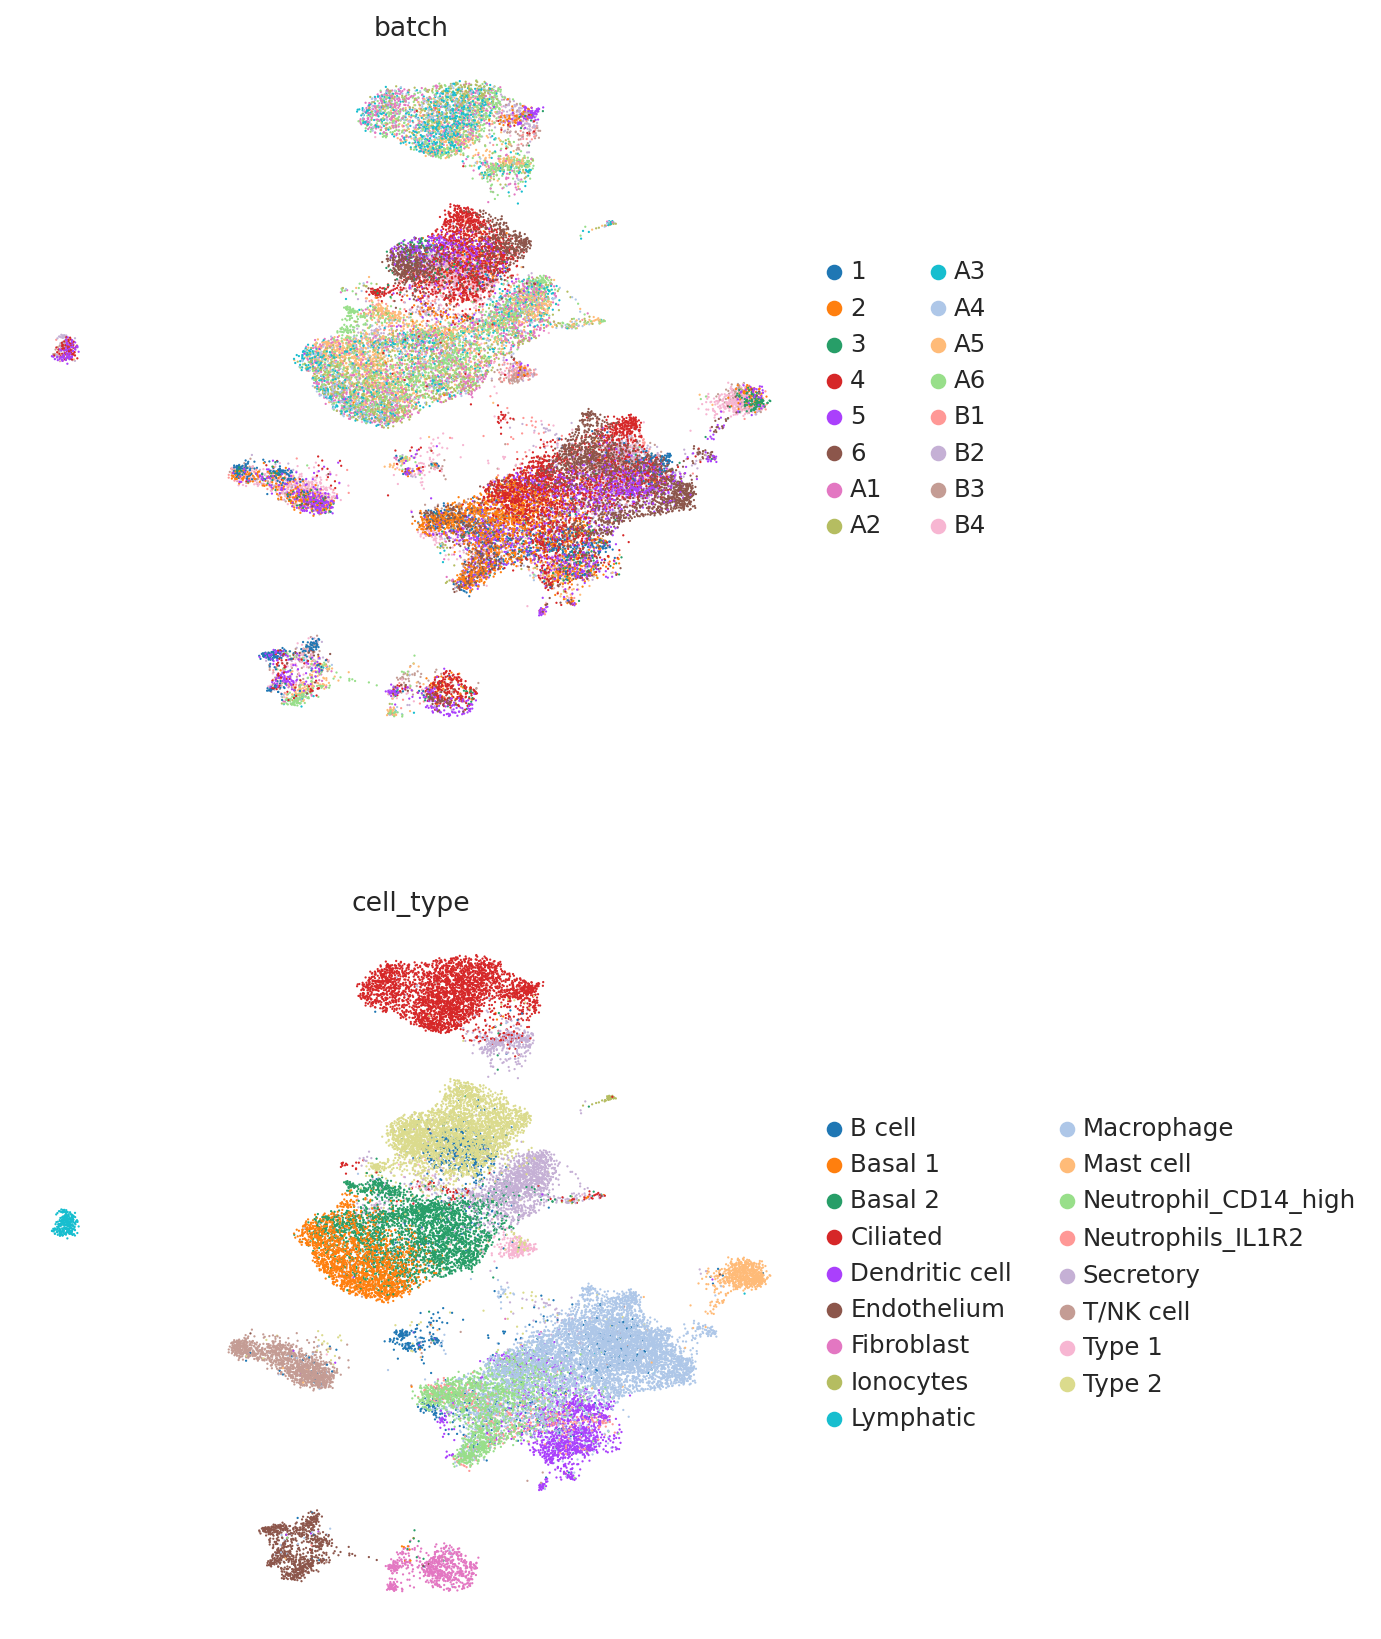

In [ ]:
sc.pl.umap(adata, color=["batch", "cell_type"], frameon=False, ncols=1)

# Harmony

In [ ]:
# Harmony
sc.tl.pca(adata, n_comps=50)
data_mat = adata.obsm['X_pca']
meta_data = adata.obs

# Specify the variables to use (as in your original code)
vars_use = ['batch']

# Run Harmony
start_time = time.time()
ho = hm.run_harmony(data_mat, meta_data, vars_use)
end_time = time.time()
training_time = end_time - start_time
print(f"Training completed in {training_time:.2f} seconds")

# Convert the adjusted PCs to a DataFrame
res = pd.DataFrame(ho.Z_corr)
res.columns = ['X{}'.format(i + 1) for i in range(res.shape[1])]

# If you want to store the adjusted PCs back into the AnnData object
adata.obsm['X_harmony'] = res.values.T
sc.pp.neighbors(adata, use_rep="X_harmony")
sc.tl.umap(adata, min_dist=0.5)

2024-07-04 12:28:39,160 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...
2024-07-04 12:28:48,203 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2024-07-04 12:28:48,282 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2024-07-04 12:28:55,211 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2024-07-04 12:29:02,002 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2024-07-04 12:29:09,263 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2024-07-04 12:29:15,983 - harmonypy - INFO - Converged after 4 iterations
INFO:harmonypy:Converged after 4 iterations


Training completed in 36.86 seconds


In [ ]:
# Save embeddings
adata.obsm["X_harmony"] = adata.obsm["X_harmony"]

# Collect embeddings
embeddings_dict["X_harmony"] = adata.obsm["X_harmony"]

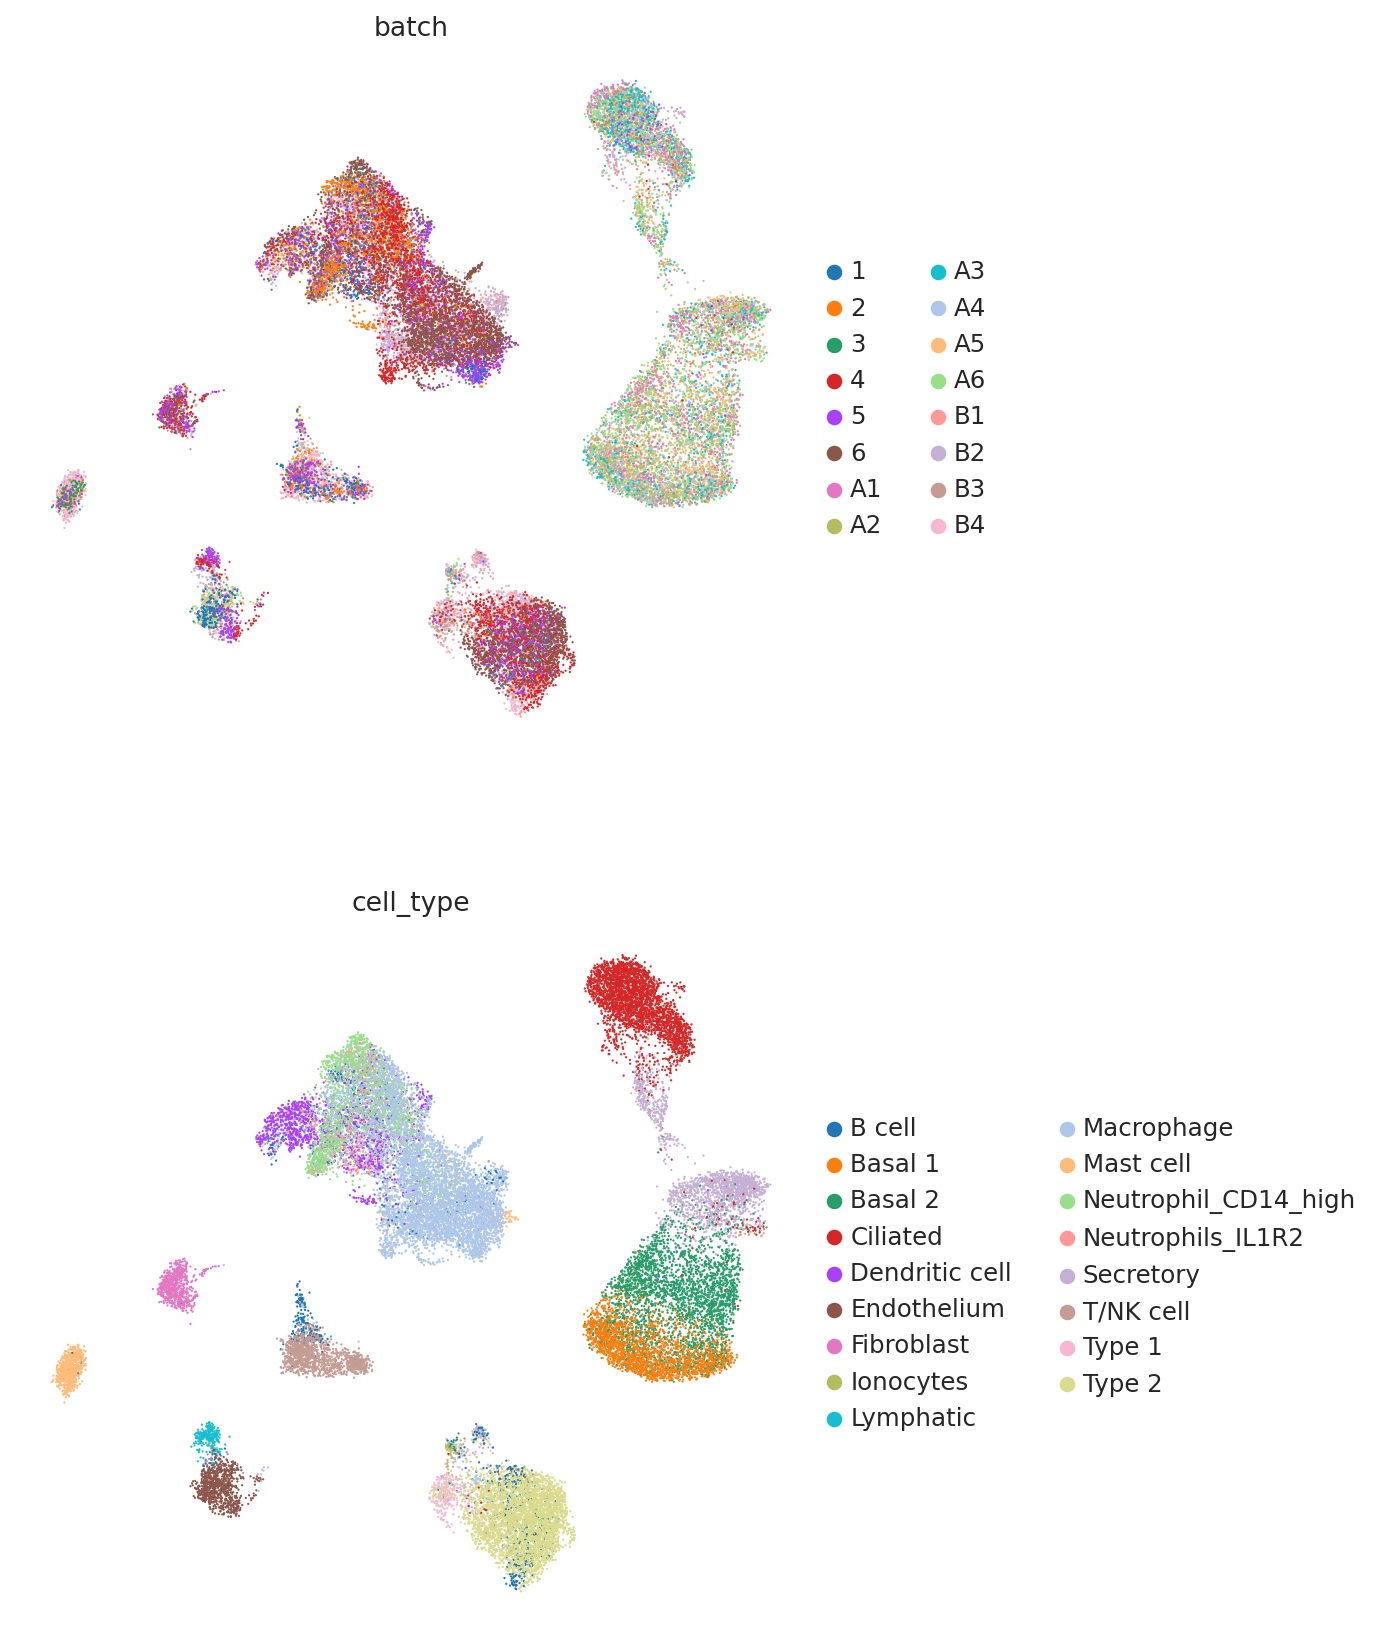

In [ ]:
sc.pl.umap(adata, color=["batch", "cell_type"], frameon=False, ncols=1)

# Seurat

In [ ]:
adata = anndata.read_h5ad("/content/drive/MyDrive/scdata/Lung_atlas_public/Lung_atlas_public.h5ad")
adata

In [ ]:
pca_embeddings = pd.read_csv('/content/drive/MyDrive/scdata/Lung_atlas_public/model_seurat/Lung_atlas_seurat.csv', index_col=0)
adata.obsm['X_seurat'] = pca_embeddings.values
sc.pp.neighbors(adata, use_rep="X_seurat")
sc.tl.umap(adata, min_dist=0.5)

In [ ]:
# Collect embeddings
embeddings_dict["X_seurat"] = adata.obsm["X_seurat"]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


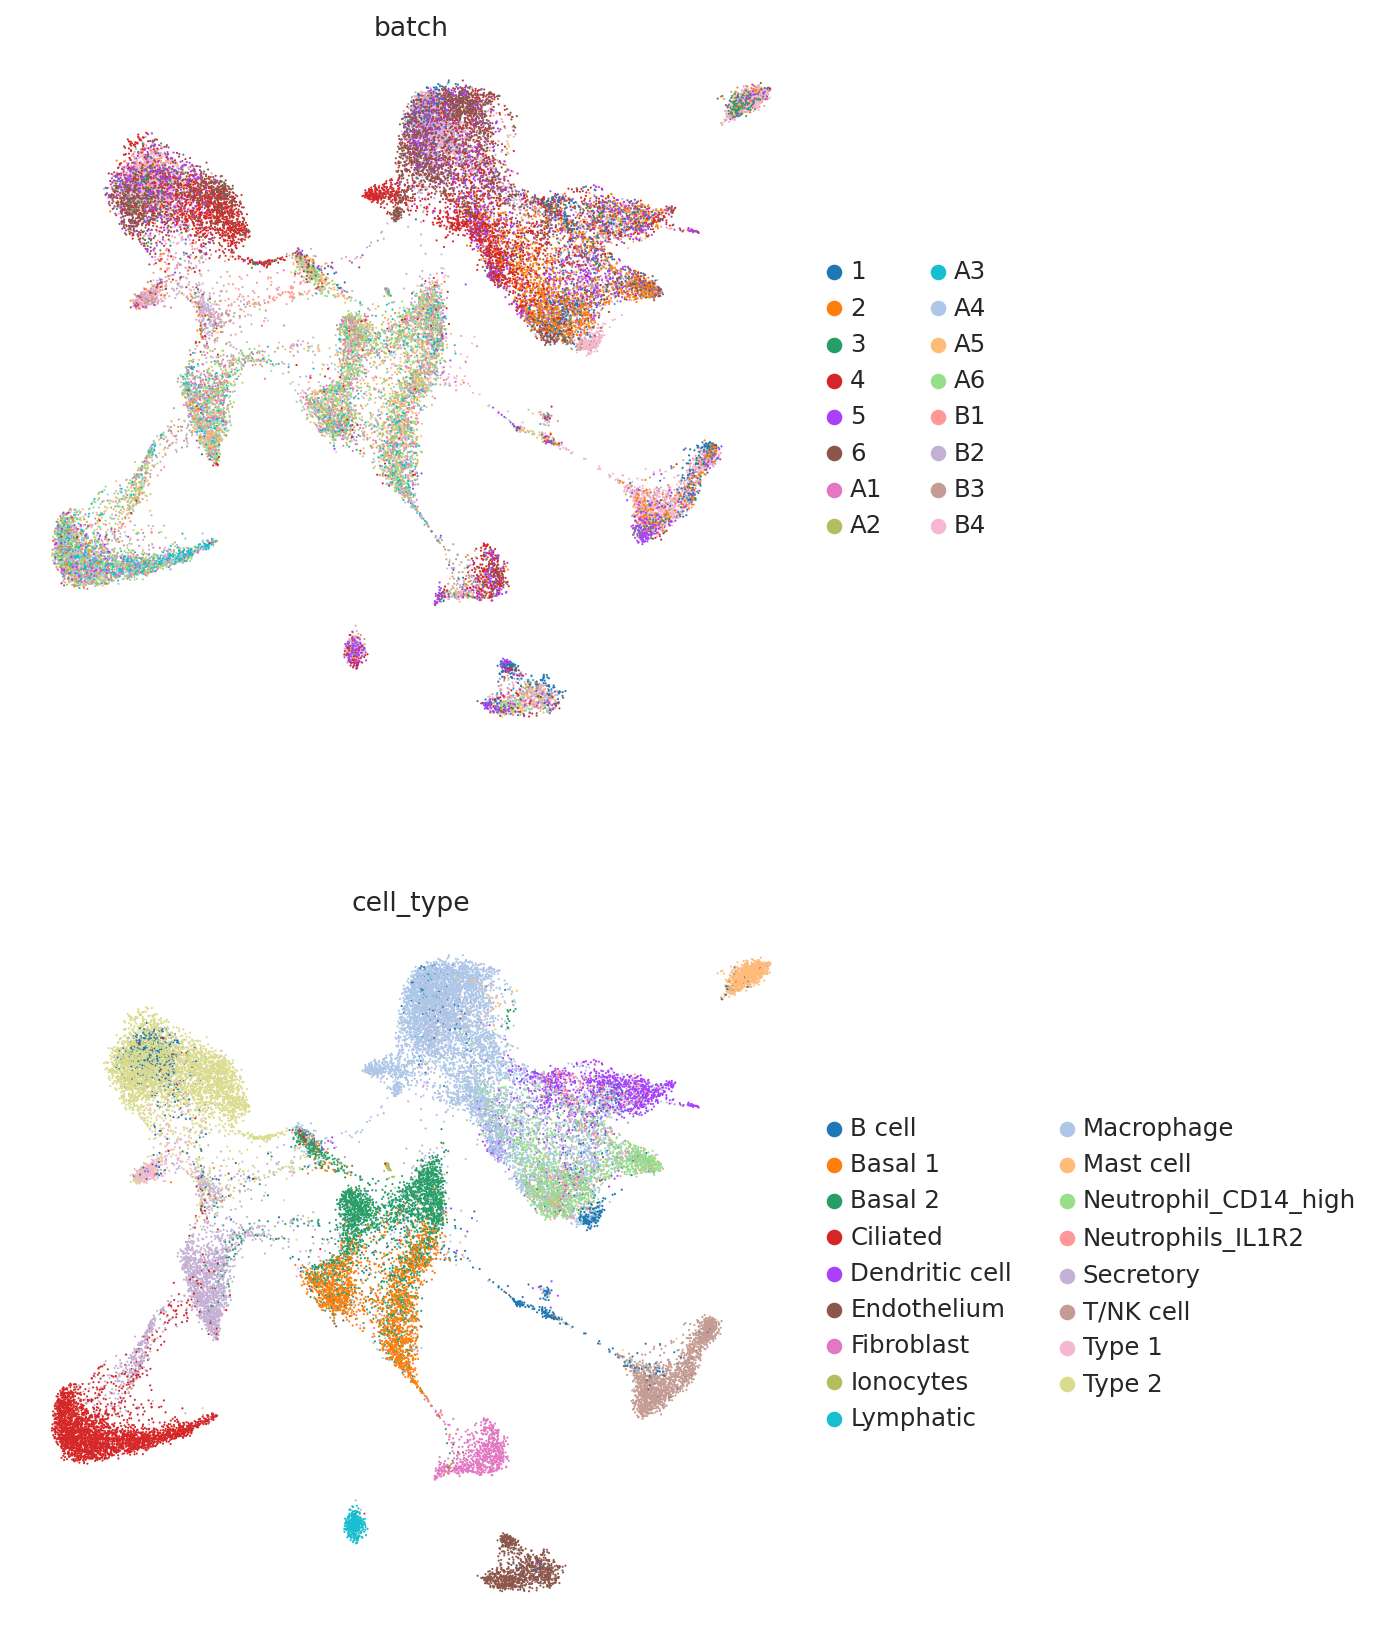

In [ ]:
sc.pl.umap(adata, color=["batch", "cell_type"], frameon=False, ncols=1)

In [27]:
# Concatenate embeddings and save to CSV
combined_embeddings = pd.concat(
    {key: pd.DataFrame(value, index=adata.obs_names) for key, value in embeddings_dict.items()},
    axis=1
)
combined_embeddings.to_csv("../embeddings/full_annotated_unsupervised_lung_atlas.csv")


# Metric Evaluation

## read the embeddings

In [23]:
# Step 1: Read the CSV file into a DataFrame
combined_embeddings = pd.read_csv("../embeddings/full_annotated_unsupervised_lung_atlas.csv", index_col=0)

# Step 2: Ensure indices match
combined_embeddings = combined_embeddings.loc[adata.obs_names]

# Step 3: Split the DataFrame into separate DataFrames for each embedding
embedding_keys = ["X_scVI", "X_harmony", "X_scCRAFT", "X_seurat"]
embeddings_dict = {key: combined_embeddings.filter(like=key) for key in embedding_keys}

# Step 4: Assign the embeddings back to adata.obsm
for key, df in embeddings_dict.items():
    adata.obsm[key] = df.values

# Now `adata.obsm` contains the loaded embeddings

In [ ]:
sc.pp.neighbors(adata, use_rep="X_scVI")
scib.me.cluster_optimal_resolution(adata, cluster_key="cluster", label_key="cell_type")
df1_1 = scib.me.metrics(adata, adata_int=adata, ari_=True, nmi_= True, isolated_labels_=True, isolated_labels_f1_=True, clisi_=True, isolated_labels_asw_=True,  batch_key='batch', label_key = 'cell_type', embed = 'X_scVI')

<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen impo

resolution: 0.1, nmi: 0.6706833446881294
resolution: 0.2, nmi: 0.7272096827987771
resolution: 0.3, nmi: 0.7276595334816134
resolution: 0.4, nmi: 0.729793190203995
resolution: 0.5, nmi: 0.7347255802090996
resolution: 0.6, nmi: 0.7555961928384615
resolution: 0.7, nmi: 0.7537964812197998
resolution: 0.8, nmi: 0.7497442998164102
resolution: 0.9, nmi: 0.7495854561681669
resolution: 1.0, nmi: 0.7458741982761319
resolution: 1.1, nmi: 0.7205885415874597
resolution: 1.2, nmi: 0.7222474180696985
resolution: 1.3, nmi: 0.7172672259000287
resolution: 1.4, nmi: 0.69671324540813
resolution: 1.5, nmi: 0.6868250365842237
resolution: 1.6, nmi: 0.6805245590941655
resolution: 1.7, nmi: 0.663074304134467
resolution: 1.8, nmi: 0.6596137295201276
resolution: 1.9, nmi: 0.6576111065776502
resolution: 2.0, nmi: 0.6526942970406453
optimised clustering against cell_type
optimal cluster resolution: 0.6
optimal score: 0.7555961928384615


/usr/local/lib/python3.10/dist-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


KeyboardInterrupt: 

In [ ]:
df1_1 = scib.me.metrics(adata, adata_int=adata, silhouette_=True, ilisi_=True, graph_conn_=True, ari_=True, nmi_= True, isolated_labels_=True, isolated_labels_f1_=True, clisi_=True, isolated_labels_asw_=True,  batch_key='batch', label_key = 'cell_type', embed = 'X_scVI')

/usr/local/lib/python3.10/dist-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...


<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: DeprecationWarning: is_sparse is deprecated and will be remove

Isolated labels F1...


/usr/local/lib/python3.10/dist-packages/scib/metrics/isolated_labels.py:272: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  batch_per_lab = tmp.groupby(label_key).agg({batch_key: "count"})


Compute neighbors on rep X_scVI
Isolated labels ASW...


/usr/local/lib/python3.10/dist-packages/scib/metrics/isolated_labels.py:272: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  batch_per_lab = tmp.groupby(label_key).agg({batch_key: "count"})
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


Graph connectivity...


/usr/local/lib/python3.10/dist-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/usr/local/lib/python3.10/dist-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/usr/local/lib/python3.10/dist-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/usr/local/lib/python3.10/dist-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/usr/local/lib/python3.1

cLISI score...
iLISI score...


In [ ]:
sc.pp.neighbors(adata, use_rep="X_harmony")
scib.me.cluster_optimal_resolution(adata, cluster_key="cluster", label_key="cell_type")
df2_1 = scib.me.metrics(adata, adata_int=adata, silhouette_=True, ilisi_=True, graph_conn_=True, ari_=True, nmi_= True, isolated_labels_=True, isolated_labels_f1_=True, clisi_=True, isolated_labels_asw_=True,  batch_key='batch', label_key = 'cell_type', embed = 'X_harmony')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


resolution: 0.1, nmi: 0.744309726539782
resolution: 0.2, nmi: 0.7656069513789596
resolution: 0.3, nmi: 0.7506991132337903
resolution: 0.4, nmi: 0.7563145036795099
resolution: 0.5, nmi: 0.7583017095654798
resolution: 0.6, nmi: 0.7512963774411456
resolution: 0.7, nmi: 0.7513025667533431
resolution: 0.8, nmi: 0.7369731979821663
resolution: 0.9, nmi: 0.7267006905817237
resolution: 1.0, nmi: 0.7437080096268318
resolution: 1.1, nmi: 0.7295857129154112
resolution: 1.2, nmi: 0.7206036202361542
resolution: 1.3, nmi: 0.717524581807609
resolution: 1.4, nmi: 0.7179141014521729
resolution: 1.5, nmi: 0.7057591865696141
resolution: 1.6, nmi: 0.6949093731904775
resolution: 1.7, nmi: 0.6895362015392175
resolution: 1.8, nmi: 0.677220942166234
resolution: 1.9, nmi: 0.6761864815530563
resolution: 2.0, nmi: 0.6762835120060595
optimised clustering against cell_type
optimal cluster resolution: 0.2
optimal score: 0.7656069513789596


/usr/local/lib/python3.10/dist-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension

Isolated labels F1...


/usr/local/lib/python3.10/dist-packages/scib/metrics/isolated_labels.py:272: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  batch_per_lab = tmp.groupby(label_key).agg({batch_key: "count"})


Compute neighbors on rep X_harmony
Isolated labels ASW...


/usr/local/lib/python3.10/dist-packages/scib/metrics/isolated_labels.py:272: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  batch_per_lab = tmp.groupby(label_key).agg({batch_key: "count"})
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


Graph connectivity...


/usr/local/lib/python3.10/dist-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/usr/local/lib/python3.10/dist-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/usr/local/lib/python3.10/dist-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/usr/local/lib/python3.10/dist-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/usr/local/lib/python3.1

cLISI score...
iLISI score...


In [ ]:
sc.pp.neighbors(adata, use_rep="X_scCRAFT")
scib.me.cluster_optimal_resolution(adata, cluster_key="cluster", label_key="cell_type")
df3_1 = scib.me.metrics(adata, adata_int=adata, silhouette_=True, ilisi_=True, graph_conn_=True, ari_=True, nmi_= True, isolated_labels_=True, isolated_labels_f1_=True, clisi_=True, isolated_labels_asw_=True,  batch_key='batch', label_key = 'cell_type', embed = 'X_scCRAFT')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


resolution: 0.1, nmi: 0.7958209362754618
resolution: 0.2, nmi: 0.795910714450984
resolution: 0.3, nmi: 0.7958430741576596
resolution: 0.4, nmi: 0.7907820595875588
resolution: 0.5, nmi: 0.7897063273467076
resolution: 0.6, nmi: 0.7897009850070962
resolution: 0.7, nmi: 0.7904037831343207
resolution: 0.8, nmi: 0.7841079328429867
resolution: 0.9, nmi: 0.7836673632673012
resolution: 1.0, nmi: 0.7836195959209197
resolution: 1.1, nmi: 0.7832275910762797
resolution: 1.2, nmi: 0.783006280424425
resolution: 1.3, nmi: 0.7823048055711903
resolution: 1.4, nmi: 0.7831023886444294
resolution: 1.5, nmi: 0.782236414765376
resolution: 1.6, nmi: 0.7803405521893791
resolution: 1.7, nmi: 0.7806820818980829
resolution: 1.8, nmi: 0.7719537242754755
resolution: 1.9, nmi: 0.7722731315095113
resolution: 2.0, nmi: 0.7663286840472177
optimised clustering against cell_type
optimal cluster resolution: 0.2
optimal score: 0.795910714450984


/usr/local/lib/python3.10/dist-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension

Isolated labels F1...
Compute neighbors on rep X_scCRAFT
Isolated labels ASW...


/usr/local/lib/python3.10/dist-packages/scib/metrics/isolated_labels.py:272: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  batch_per_lab = tmp.groupby(label_key).agg({batch_key: "count"})
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


Graph connectivity...


/usr/local/lib/python3.10/dist-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/usr/local/lib/python3.10/dist-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/usr/local/lib/python3.10/dist-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/usr/local/lib/python3.10/dist-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/usr/local/lib/python3.1

cLISI score...
iLISI score...


In [ ]:
sc.pp.neighbors(adata, use_rep="X_seurat")
scib.me.cluster_optimal_resolution(adata, cluster_key="cluster", label_key="cell_type")
df4_1 = scib.me.metrics(adata, adata_int=adata, silhouette_=True, ilisi_=True, graph_conn_=True, ari_=True, nmi_= True, isolated_labels_=True, isolated_labels_f1_=True, clisi_=True, isolated_labels_asw_=True,  batch_key='batch', label_key = 'cell_type', embed = 'X_seurat')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


resolution: 0.1, nmi: 0.7419976203444669
resolution: 0.2, nmi: 0.7410886236452974
resolution: 0.3, nmi: 0.7446064926442925
resolution: 0.4, nmi: 0.732401069712537
resolution: 0.5, nmi: 0.7179726698790524
resolution: 0.6, nmi: 0.7105967321744299
resolution: 0.7, nmi: 0.7138039200670052
resolution: 0.8, nmi: 0.7116369139293907
resolution: 0.9, nmi: 0.7154319821116525
resolution: 1.0, nmi: 0.702115895006619
resolution: 1.1, nmi: 0.6843286936997451
resolution: 1.2, nmi: 0.6816533775081288
resolution: 1.3, nmi: 0.6820051992742121
resolution: 1.4, nmi: 0.6762468347450148
resolution: 1.5, nmi: 0.6737597930799806
resolution: 1.6, nmi: 0.6741753878877572
resolution: 1.7, nmi: 0.6721924455306147
resolution: 1.8, nmi: 0.6715271094489855
resolution: 1.9, nmi: 0.6691753610707805
resolution: 2.0, nmi: 0.6634771832749856
optimised clustering against cell_type
optimal cluster resolution: 0.3
optimal score: 0.7446064926442925


/usr/local/lib/python3.10/dist-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension

Isolated labels F1...


/usr/local/lib/python3.10/dist-packages/scib/metrics/isolated_labels.py:272: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  batch_per_lab = tmp.groupby(label_key).agg({batch_key: "count"})


Compute neighbors on rep X_seurat
Isolated labels ASW...


/usr/local/lib/python3.10/dist-packages/scib/metrics/isolated_labels.py:272: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  batch_per_lab = tmp.groupby(label_key).agg({batch_key: "count"})
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


Graph connectivity...


/usr/local/lib/python3.10/dist-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/usr/local/lib/python3.10/dist-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/usr/local/lib/python3.10/dist-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/usr/local/lib/python3.10/dist-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/usr/local/lib/python3.1

cLISI score...
iLISI score...


In [ ]:
# Adding new columns to each dataframe
df1_1['scVI'] = df1_1.iloc[:, 0]
df2_1['Harmony'] = df2_1.iloc[:, 0]
df3_1['scCRAFT'] = df3_1.iloc[:, 0]
df4_1['Seurat'] = df4_1.iloc[:, 0]

# Selecting only the new columns to avoid duplicate data
df1_1 = df1_1[['scVI']]
df2_1 = df2_1[['Harmony']]
df3_1 = df3_1[['scCRAFT']]
df4_1 = df4_1[['Seurat']]

# Merging the dataframes along the columns
merged_df = pd.concat([df1_1, df2_1, df3_1, df4_1], axis=1)

merged_df

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bo

scVI   Harmony   scCRAFT    Seurat
NMI_cluster/label          0.746023  0.758989  0.795734  0.739844
ARI_cluster/label          0.606035  0.601248  0.708516  0.569116
ASW_label                  0.525720  0.577140  0.594147  0.598803
ASW_label/batch            0.902066  0.889591  0.898017  0.867750
PCR_batch                       NaN       NaN       NaN       NaN
cell_cycle_conservation         NaN       NaN       NaN       NaN
isolated_label_F1          0.783734  0.623288  0.515385  0.789298
isolated_label_silhouette  0.536205  0.516742  0.612425  0.634938
graph_conn                 0.963363  0.943701  0.931117  0.929199
kBET                            NaN       NaN       NaN       NaN
iLISI                      0.188094  0.177098  0.203928  0.193386
cLISI                      0.978824  0.991996  0.992918  0.986986
hvg_overlap                     NaN       NaN       NaN       NaN
trajectory                      NaN       NaN       NaN       NaN